# 応用情報工学演習：Scikit-Learnマスターコース
## 実践編 配布用コードファイル

#### 基本ライブラリの読み込み

In [2]:
import os, sys
import glob

import warnings
warnings.simplefilter('ignore')

import numpy as np
import cv2 as cv
from sklearn.metrics import accuracy_score

from PIL import Image

np.random.seed(1)

#### データ読み込み関数

In [3]:
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#                               このセルは変更を禁止します                                  #
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#-------------------------------------------------------------------------------------------#
#-                                  データ読み込み関数                                     -#
#-------------------------------------------------------------------------------------------#
def load_data_(root_dir='../data/gw_dataset'):
    """
    グループワーク用　学習用データ読み込み関数

    Args:
        * root_dir: 配布したgw_datasetへのパスを指定する (default: '../data/gw_dataset')
        
    Output:
        * X_train:  正解ラベル付き学習用画像   shape: (140x150,528)
                    1行あたり、画像1枚の画素値を格納したnp.array
                    画像140枚、各画像224x224=150,528次元のベクトル
                    
        * y_train:  X_trainの正解ラベル        shape: (140, )
                    クラス数は7　140枚分のクラスラベル（0～6）の整数が格納されている
        
        * X_trainu: 正解ラベルなし学習用画像   shape: (210x150,528)
                    形式はX_trainと同じ
                    
        * X_val:   正解ラベル付き検証用画像   shape: (70x150,528)
                    形式はX_trainと同じ
                    
        * y_val:    X_valの正解ラベル          shape: (70, )
                    形式はy_valと同じ                             
    """
    
    #----------------- 学習用データの読み込み -------------------#
    train_paths = sorted(glob.glob(os.path.join(root_dir, "train", "*.png")))
    
    X_train = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in train_paths])
    y_train = np.load(os.path.join(root_dir, "y_train.npy"))

    #------------ ラベルなし学習用データの読み込み --------------#
    trainu_paths = sorted(glob.glob(os.path.join(root_dir, "train-u", "*.png")))
    X_trainu = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in trainu_paths])
    
    #----------------- 検証用データの読み込み -------------------#
    val_paths = sorted(glob.glob(os.path.join(root_dir,"val", "*.png")))
    X_val = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in val_paths])
    y_val = np.load(os.path.join(root_dir, "y_val.npy"))

    return X_train, y_train, X_trainu, X_val, y_val

In [4]:
### データ読み込み関数の実行
X_train, y_train, X_trainu, X_val, y_val = load_data_() # すべて必要な場合
print(X_train.shape, y_train.shape, X_trainu.shape, X_val.shape, y_val.shape)

# X_train, y_train, _, X_val, y_val = load_data_() # いらないデータがある場合
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(140, 150528) (140,) (210, 150528) (70, 150528) (70,)


#### 評価関数

In [5]:
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#                               このセルは変更を禁止します                                  #
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#-------------------------------------------------------------------------------------------#
#-                                       評価関数                                          -#
#-------------------------------------------------------------------------------------------#

def eval_(y_pred):
    """
    グループワーク用　評価関数
    実行する前にy_valがglobalスコープに読み込まれている必要がある

    Args:
        * y_pred:   識別結果　y_valと同形式・同shapeでなければならない
    """

    try:
        y_val
    except NameError as e:
        print("y_valが読み込まれていません")
        
    assert y_pred.shape == y_val.shape, 'y_predとy_valのサイズが一致しません'
    
    print("valデータでの識別精度:{0:.3f}".format(accuracy_score(y_val, y_pred)))

## データ拡張のクラス

(150, 224, 224, 3)
(150,)


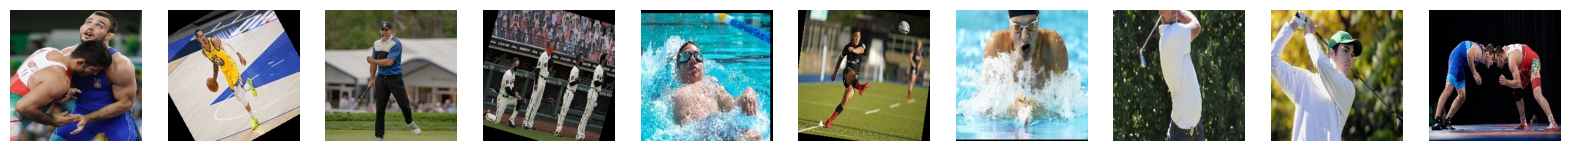

In [6]:
###########################
#    Data Augmentation    #
###########################
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image,ImageOps


class ImageGenerator:
    """データ拡張クラス"""
    
    def __init__(self, seed=100):
        """コンストラクタ"""
        random.seed(seed)

    def zoom_at(self, img, x, y, zoom):
        """特定の座標をズーム"""
        w_, h_ = img.size
        zoom2_ = zoom * 2
        img = img.crop((x - w_ / zoom2_, y - h_ / zoom2_, 
                        x + w_ / zoom2_, y + h_ / zoom2_))
        return img.resize((w_, h_), Image.LANCZOS)

    def generate(self, X, y, size=200):
        """データ拡張"""
        X_ = X.reshape(-1,224,224,3)
        y_ = y

        #debug
        #print(X_.shape)
        #print(len(X_))

        if size < len(X_):
            print("size must be larger than dataset length")
            

        # 拡張するデータ数
        n = size - len(X_)

        # 拡張の対象になるデータを選択
        nw_ = np.arange(0, len(X_))
        w_ = random.choices(nw_, k=n)
        
        for i in range(0,n):
            y_ = np.append(y_, y[w_[i]])
            W_ = Image.fromarray(X_[w_[i]].astype(np.uint8))

            # 4種類から選んでランダムに適応
            rd_ = random.random()
            
            # グレースケール化
            if rd_ < 0.03:
                W_ = W_.convert('L').convert('RGB')
            
            # 回転
            elif rd_ < 0.3:
                W_ = W_.rotate(random.randrange(-30,30), resample=Image.BICUBIC)
            
            # ズーム
            elif rd_ < 0.6:
                W_ = self.zoom_at(W_, random.uniform(74,150), random.uniform(74,150), random.uniform(1.1,1.5))

            # 反転
            else:
                W_ = ImageOps.mirror(W_)
                
            # datasetに追加
            X_ = np.append(X_, np.array(W_).astype(np.float32)[np.newaxis, ...], axis=0)
            # print(X_.shape)

        # データ拡張を施したdatasetを返す
        return X_.reshape(size, -1), y_

    def debug(self, X, y, size=100):
        """デバッグ"""
        X_da, y_da = self.generate(X, y, size)
        X_da = X_da.reshape(-1,224,224,3)
        print(X_da.shape)
        print(y_da.shape)

        plt.figure(figsize=(20,10))
        for i in range(0, 10):
            ax = plt.subplot(1,10,i+1)
            plt.imshow(X_da[len(X)+i-1].astype(np.uint8))
            ax.set_axis_off()
        plt.show()

da = ImageGenerator()
da.debug(X_train, y_train, len(X_train)+10)

In [17]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

da = ImageGenerator()
X_train_da, y_train_da = da.generate(X_train, y_train, len(X_train)+200)
print(X_train_da.shape)
print(y_train_da.shape)

# svc = SVC(kernel='rbf', C=100, probability=True)
# svc.fit(X_train, y_train)
# svc.fit(X_train_da, y_train_da)
# y_pred = svc.predict(X_train)
# print("SVC:trainデータでの識別精度:{0:.3f}".format(accuracy_score(y_train, y_pred
# y_pred = svc.predict(X_val)     # X_valの識別結果をy_predに格納
# eval_(y_pred)

estimators = [
        ('SYC', SVC(kernel='rbf', C=100, probability=True)),
        ('RF', RandomForestClassifier(n_estimators=100))
        ]

clf = VotingClassifier(estimators=estimators, voting='soft', weights=(0.7,0.3))

parameters = {'RF__n_estimators': [500,1000]}

gsv = GridSearchCV(clf, parameters, cv=3, n_jobs=-1)

gsv.fit(X_train_da, y_train_da)
best_clf = gsv.best_estimator_
pd.DataFrame.from_dict(gsv.cv_results_)

(340, 150528)
(340,)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RF__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,124.368567,2.292867,3.524082,0.049467,500,{'RF__n_estimators': 500},0.649123,0.707965,0.699115,0.685401,0.025906,1
1,138.241407,2.022573,2.927513,0.035041,1000,{'RF__n_estimators': 1000},0.649123,0.716814,0.690265,0.685401,0.027848,1


In [19]:
y_pred = best_clf.predict(X_train)
print("Voting:trainデータでの識別精度:{0:.3f}".format(accuracy_score(y_train, y_pred)))
y_pred = best_clf.predict(X_val)
eval_(y_pred)

Voting:trainデータでの識別精度:1.000
valデータでの識別精度:0.557


In [20]:
## selftraining
X_semitrain_da = np.concatenate([X_train_da, X_trainu])
y_trainu = np.full(210, -1)
y_semitrain_da = np.concatenate([y_train_da, y_trainu])

# for i in range(250, 100, -10):
print("k_best:{}".format(110))
clf = SelfTrainingClassifier(base_estimator=best_clf, criterion='k_best', k_best=110) # オブジェクト作成
clf.fit(X_semitrain_da, y_semitrain_da)       # fit
y_pred = clf.predict(X_train)
print("SelfTraining:trainデータでの識別精度:{0:.3f}".format(accuracy_score(y_train, y_pred)))

y_pred = clf.predict(X_val)     # X_valの識別結果をy_predに格納
eval_(y_pred)

k_best:110
SelfTraining:trainデータでの識別精度:1.000
valデータでの識別精度:0.614
